Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from IPython.display import Image as img_ipyt
from IPython.display import display

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# разделение на тестовую и тренировочную выборки
dataset = ImageFolder("C:\\Users\\123\\PycharmProjects\\Pytorch\\cat-and-dogs\\training_set\\training_set\\")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)


# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")):  
                datasetRGB.append(dataset[index])
        return datasetRGB

Преобразование изображений к единому виду

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)
])  # train transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)
])  # test transform

train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Импорт ResNet

In [10]:
from tqdm import tqdm
from torchvision import models

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
num_ftrs

2048

Тренировка и тест модели

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Train and test

def train(num_epoch, model):
    for epoch in range(0, num_epoch):
        #         current_loss = 0.0
        #         current_corrects = 0
        losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader))  # create a progress bar
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)

            loss = criterion(scores, targets)
            optimizer.zero_grad()
            losses.append(loss)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)
            #             current_loss += loss.item() * data.size(0)
            #             current_corrects += (preds == targets).sum().item()
            #             accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            loop.set_description(f"Epoch {epoch + 1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())

        # save model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'checpoint_epoch_' + str(epoch) + '.pt')


# model.eval()

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)

    test_loss /= len(test_loader.dataset)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
          len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

In [11]:
if __name__ == "__main__":
    train(5, model)  # train
    test()  # test

Epoch 5/5 process: 99: 100%|██████████| 101/101 [12:45<00:00,  7.58s/it, loss=0.000235]


Average Loss:  tensor(0.)   Accuracy:  1567  /  1601    97 %


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
checkpoint = torch.load("./checpoint_epoch_4.pt")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [12]:
# Check the test set
dataset = ImageFolder("C:\\Users\\123\\PycharmProjects\\Pytorch\\cat-and-dogs\\test_set\\test_set\\",
                      transform=transforms.Compose([
                          transforms.Resize((224, 224)),
                          transforms.ToTensor(),
                          transforms.Normalize([0.5] * 3, [0.5] * 3)
                      ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 2023
    Root location: C:\Users\123\PycharmProjects\Pytorch\cat-and-dogs\test_set\test_set\
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [14]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])
    img = data_transforms(img_array).unsqueeze(
        dim=0)
    load = DataLoader(img)

    for x in load:
        x = x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        # print(f"class : {preds}")
        if preds[0] == 1:
            print(f"predicted ----> Dog")
        else:
            print(f"predicted ----> Cat")

predicted ----> Dog


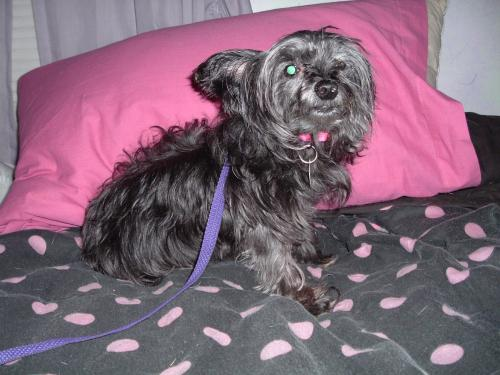

predicted ----> Cat


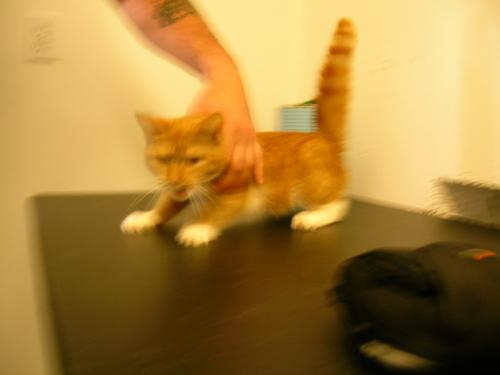

predicted ----> Dog


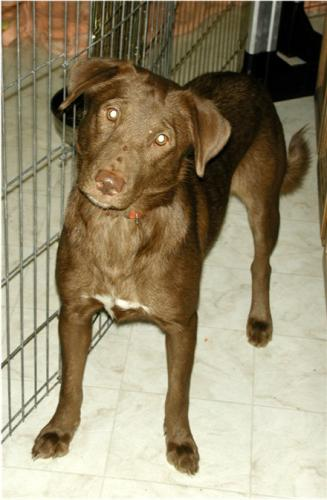

predicted ----> Cat


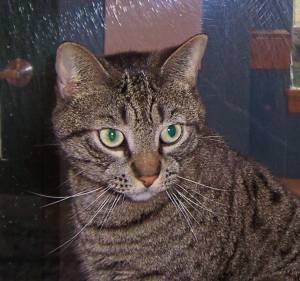

predicted ----> Dog


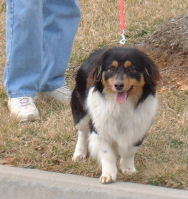

predicted ----> Cat


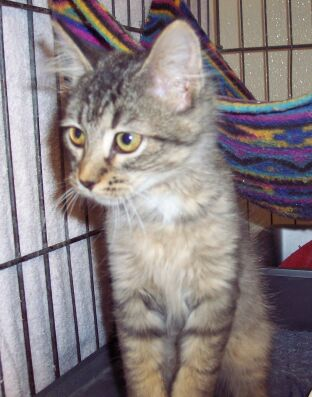

predicted ----> Dog


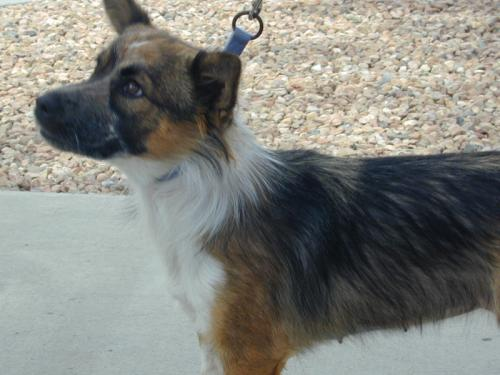

predicted ----> Cat


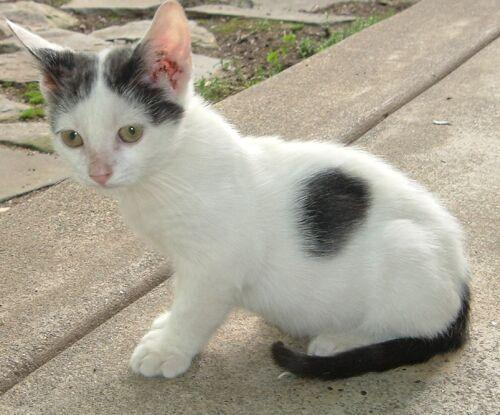

predicted ----> Dog


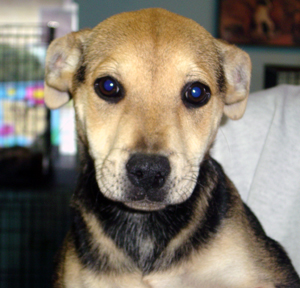

predicted ----> Cat


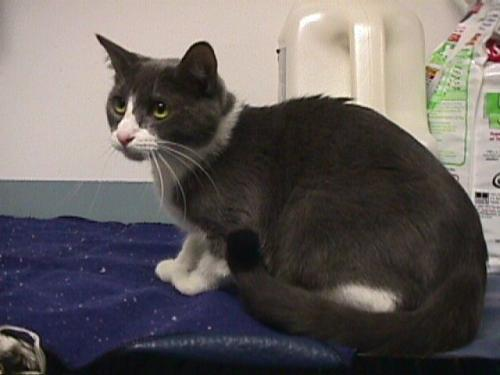

In [15]:
for i in range(5):
    RandomImagePrediction(f'C:\\Users\\123\\PycharmProjects\\Pytorch\\dogvscat_small\\train\\dogs\\{i}.jpg')
    display(img_ipyt(f'C:\\Users\\123\\PycharmProjects\\Pytorch\\dogvscat_small\\train\\dogs\\{i}.jpg'))

    RandomImagePrediction(f'C:\\Users\\123\\PycharmProjects\\Pytorch\\dogvscat_small\\train\\cats\\{i}.jpg')
    display(img_ipyt(f'C:\\Users\\123\\PycharmProjects\\Pytorch\\dogvscat_small\\train\\cats\\{i}.jpg'))
